In [1]:
from snake_v0_ai import Game, RenderMode
from state_preprocessors import preprocess_frame, frame_to_vector_distanced
from elitism import eaSimpleElitism

import numpy as np
import matplotlib.pyplot as plt

from deap import base
from deap import creator
from deap import tools
from deap import algorithms

from functools import partial
from IPython.display import clear_output
from abc import ABC, abstractmethod
from typing import Self, TypeVar, Sequence, Literal
import multiprocessing
import pickle

pygame 2.5.2 (SDL 2.28.2, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
T = TypeVar("T")

# Consts
INDIVID_SIZE: int
POPULATION_SIZE = 1000
P_CROSSINGOCER = 0.9
P_MUTATION = 0.1
N_GENERATIONS = 200
HALL_OF_FAME_SIZE = 3

UP = 1
LOW = -1
ETA = 20

FIELD_SIZE = 10
D_VECTOR_SIZE = 18

WEIGHTS_DIRECTORY = "genetic_algorithms"

In [3]:
class Activation(ABC):
    
    @abstractmethod
    def __call__(self, x: T) -> T: ...

class ReLU(Activation):
    
    def __call__(self, x: T) -> T:
        x[x < 0] = 0
        return x
    
class BinStep(Activation):

    def __call__(self, x: T) -> T:
        x[x < 0] = 0
        x[x > 0] = 1
        return x

class Softmax(Activation):
    
    def __call__(self, x: T) -> T:
        exp = np.exp(x)
        exp_sum = exp.sum()
        return np.round(exp/exp_sum, 3)

class Sigmoid(Activation):

    def __call__(self, x: T) -> T:
        exp = np.exp(x)
        return exp / (1 + exp)

In [4]:
class Layer(ABC):

    @abstractmethod
    def __init__(self, in_params: int, out_params: int) -> None:
        self.shape: tuple[int]
    
    @abstractmethod    
    def __call__(self, x: T) -> T: ...

    @property
    @abstractmethod
    def weights(self): ...
    
    @weights.setter
    @abstractmethod
    def weights(self): ...

class Linear(Layer):

    def __init__(self, in_params: int, out_params: int, bias: bool = True) -> None:
        self.__weights = self.__init_weights(in_params, out_params, bias)
        self.__with_bias = bias
        self.shape = (in_params, out_params)

    
    def __call__(self, x: T) -> T:
        w, b = self.__weights
        res = x@w
        if self.__with_bias:
            res += b
        return res
        
    def __init_weights(self, in_params: int, out_params: int, bias: bool = True) -> tuple[np.ndarray, np.ndarray]:
        w = np.random.uniform(-1., 1., (in_params, out_params))
        b = np.random.uniform(-1., 1., (out_params,)) if bias else None
        return w, b
    
    @property
    def weights(self) -> tuple[np.ndarray, np.ndarray]:
        w, b = self.__weights
        return w.copy(), b.copy() if self.__with_bias else None
    
    @weights.setter
    def weights(self, weights: tuple[Sequence, Sequence]) -> None:
        w, b = weights

        w = np.array(w)
        assert self.__weights[0].size == w.size
        w = w.reshape(self.__weights[0].shape)

        if self.__with_bias:
            b = np.array(b)
            assert self.__weights[1].size == b.size
            b = b.reshape(self.__weights[1].shape)

        else:
            b = None

        self.__weights = (w, b)

In [5]:
class NN:

    def __init__(self):
        self.__configuration: tuple[Layer | Activation]
        self.__layers: list[Layer]

    def __call__(self, x: np.ndarray) -> np.ndarray:
        for param in self.__configuration:
            x = param(x)
        return x
    
    @classmethod
    def create(cls, *params: Layer | Activation) -> Self:                    
        self = cls()
        self.__configuration = params
        self.__layers = [param for param in params if isinstance(param, Layer)]
        return self
    
    @classmethod
    def from_config(cls, params: str, mode: Literal["txt", "json", "yaml"] = "txt") -> Self:
        match mode:
            case "txt":
                params = eval(f"[{params}]")
                
            case "json":
                ...

            case "yaml":
                ...
        return cls.create(*params)
    
    @property
    def parameters(self):
        return [layer.weights for layer in self.__layers]
    
    def get_weights(self):
        res = []
        for w, b in self.parameters:
            res += w.flatten().tolist()
            res += b.flatten().tolist()
        return res           

    def set_weights(self, weights: list):
        for layer in self.__layers:
            s1, s2 = layer.shape
            num_elements = (s1 + 1) * s2
            elements = weights[:num_elements]
            layer_w = elements[:-s2]
            layer_b = elements[-s2:]
            layer.weights = layer_w, layer_b
            weights = weights[num_elements:]

In [22]:
env = Game(FIELD_SIZE, mode=RenderMode.DISTANCED_VECTOR, verbose=False)

In [7]:
nn = NN.create(
    Linear(D_VECTOR_SIZE, 32),
    ReLU(),
    Linear(32, 20),
    ReLU(),
    Linear(20, 12),
    ReLU(),
    Linear(12, 3),
    Softmax(),
)

In [8]:
# Model for vecorized input
with open("weights/vectorized/conf.txt") as conf:
    nn = NN.from_config(conf.read())

In [86]:
# Model for image input
with open("weights/imaged/conf.txt") as conf:
    nn = NN.from_config(conf.read())

In [8]:
INDIVID_SIZE = len(nn.get_weights())
print(INDIVID_SIZE)

1559


In [9]:
vars(nn)

{'_NN__configuration': (<__main__.Linear at 0x7f1d19132450>,
  <__main__.Softmax at 0x7f1d19132590>),
 '_NN__layers': [<__main__.Linear at 0x7f1d19132450>,
  <__main__.Linear at 0x7f1d191327d0>]}

In [10]:
def save_population(population_obj, path: str):
    with open(path, "wb") as file:
        pickle.dump(population_obj, file)

def load_population(path: str):
    with open(path, "rb") as file:
        return pickle.load(file)

In [11]:
def simulated_binary_crossover(parent1: np.ndarray, parent2: np.ndarray, eta: float) -> tuple[np.ndarray, np.ndarray]:
    rand = np.random.random(parent1.shape)
    gamma = np.empty(parent1.shape)
    gamma[rand <= 0.5] = (2 * rand[rand <= 0.5]) ** (1.0 / (eta + 1))
    gamma[rand > 0.5] = (1.0 / (2.0 * (1.0 - rand[rand > 0.5]))) ** (1.0 / (eta + 1))

    chromosome1 = creator.Individ( 0.5 * ((1 + gamma)*parent1 + (1 - gamma)*parent2) )
    chromosome2 = creator.Individ( 0.5 * ((1 - gamma)*parent1 + (1 + gamma)*parent2) )

    return chromosome1, chromosome2

In [12]:
creator.create("FitnessMax", base.Fitness, weights=(1.,))
creator.create("Individ", np.ndarray, fitness=creator.FitnessMax)

In [13]:
toolbox = base.Toolbox()

In [14]:
toolbox.register("init_weights", np.random.triangular, -1., 0, 1., (INDIVID_SIZE,))
toolbox.register("create_individ", lambda x: creator.Individ(x()), toolbox.init_weights)
toolbox.register("create_population", tools.initRepeat, list, toolbox.create_individ)

In [15]:
population = toolbox.create_population(POPULATION_SIZE)

In [16]:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE, similar=np.array_equal)

In [17]:
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", simulated_binary_crossover, eta=ETA)
# toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=LOW, up=UP, indpb=1./5)
toolbox.register("mutate", tools.mutGaussian, mu=1, sigma=0, indpb=1./4)

In [24]:
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

In [18]:
stats = tools.Statistics(lambda x: x.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# Brute force straight from image

In [19]:
# population = load_population("weights/imaged/population.pickle")

In [15]:
def play_game(ind):
    nn.set_weights(ind)
    state, _ = env.reset()
    total_steps = 0
    steps_without_reward = 0
    done = False
    while not done:
        state = preprocess_frame(state).flatten()
        action = np.argmax(nn(state)) - 1
        state, reward, done, _ = env.step(action)
        total_steps += 1
        steps_without_reward += 1
        if reward == 1:
            steps_without_reward = 0
        if steps_without_reward > 50:
            break
        
    apples_eaten = env.score - 3 # 3 is snake initial size that also counting as scores
    total_reward = total_steps + (2**apples_eaten + apples_eaten**2.1 * 500) - (apples_eaten**1.2 * (total_steps / 4)**1.3)
    return total_reward,

In [ ]:
toolbox.register("evaluate", play_game)

In [42]:
population, logboook = eaSimpleElitism(
    population,
    toolbox,
    cxpb=P_CROSSINGOCER,
    mutpb=P_MUTATION,
    # ngen=N_GENERATIONS,
    ngen=1000,
    stats=stats,
    halloffame=hof,
    verbose=True,
)

gen	nevals	max  	avg    
0  	0     	14702	319.617


/home/alex/.cache/pypoetry/virtualenvs/q-learning-practice-7b5l1J-R-py3.11/lib64/python3.11/site-packages/deap/tools/mutation.py:85: RuntimeWarning: invalid value encountered in scalar power
  delta_q = val ** mut_pow - 1.0
/home/alex/.cache/pypoetry/virtualenvs/q-learning-practice-7b5l1J-R-py3.11/lib64/python3.11/site-packages/deap/tools/mutation.py:89: RuntimeWarning: invalid value encountered in scalar power
  delta_q = 1.0 - val ** mut_pow


1  	904   	14702	230.429
2  	894   	14702	258.152
3  	912   	14702	256.367
4  	904   	14702	265.833
5  	904   	14702	255.468
6  	902   	14702	274.308
7  	917   	14702	254.106
8  	898   	14702	255.79 
9  	916   	14702	263.136
10 	920   	14702	263.538
11 	910   	14702	245.335
12 	905   	14702	248.586
13 	922   	14702	256.253
14 	915   	14702	256.979
15 	916   	14702	263.918
16 	910   	14702	290.782
17 	912   	14702	259.91 
18 	914   	14702	267.862
19 	897   	14702	312.093
20 	893   	14702	310.629
21 	909   	14702	284.487
22 	909   	14702	289.375
23 	915   	14702	313.803
24 	904   	14702	263.171
25 	889   	14702	284.366
26 	912   	14702	270.268
27 	926   	14702	230.541
28 	912   	14702	259.176
29 	907   	14702	256.32 
30 	907   	14702	255.127
31 	899   	14702	282.529
32 	905   	14702	265.009
33 	915   	14702	269.943
34 	886   	14702	287.127
35 	901   	14702	270.43 
36 	900   	14702	250.696
37 	924   	14702	270.818
38 	907   	14702	257.01 
39 	912   	14702	253.368
40 	907   	14702	263.6  


KeyboardInterrupt: 

In [29]:
# save_population(population, "weights/imaged/population.pickle")

In [253]:
def show_game(ind):
    nn.set_weights(ind)
    state, _ = env.reset()
    total_steps = 0
    steps_without_reward = 0
    done = False
    while not done:
        clear_output(True)
        plt.imshow(state)
        plt.show()
        state = preprocess_frame(state).flatten()
        action = np.argmax(nn(state)) - 1
        state, reward, done, _ = env.step(action)
        total_steps += 1
        steps_without_reward += 1
        if reward == 1:
            steps_without_reward = 0
        if steps_without_reward > 50:
            break
        

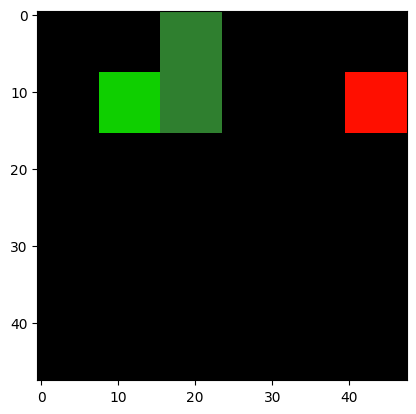

In [254]:
show_game(population[0])

# Now try vectorized

In [21]:
# population = load_population("weights/vectorized/population.pickle")

In [19]:
def play_game_vectorized(ind):
    nn.set_weights(ind)
    state, _ = env.reset()
    total_steps = 0
    steps_without_reward = 0
    done = False

    while not done:
        action = np.argmax(nn(state)) - 1
        state, reward, done, _ = env.step(action)
        total_steps += 1
        steps_without_reward += 1
        if reward == 10:
            steps_without_reward = 0

        if steps_without_reward > 120:
            break
        
    apples_eaten = env.score - 3 # 3 is snake initial size that also counting as scores
    total_reward = total_steps + (2**apples_eaten + apples_eaten**2.1 * 500) - (apples_eaten**1.2 * (total_steps / 4)**1.3)
    return total_reward,

In [20]:
toolbox.register("evaluate", play_game_vectorized)

In [25]:
population, logboook = eaSimpleElitism(
    population,
    toolbox,
    cxpb=P_CROSSINGOCER,
    mutpb=P_MUTATION,
    ngen=300,
    stats=stats,
    halloffame=hof,
    verbose=True,
)

gen	nevals	max    	avg    
0  	0     	2149.48	85.0098
1  	900   	2149.48	111.986
2  	905   	2149.48	114.93 
3  	906   	2149.48	116.823
4  	906   	2149.48	120.863
5  	886   	2149.48	127.501
6  	916   	2149.95	121.373
7  	936   	2149.95	117.102
8  	917   	2149.95	122.667
9  	901   	2149.95	129.175
10 	917   	2149.95	128.094
11 	911   	2149.95	123.418
12 	904   	2149.95	134.739
13 	908   	2149.95	125.511
14 	901   	2149.95	129.741
15 	902   	2149.95	128.026
16 	905   	2149.95	136.22 
17 	904   	2149.95	134.594
18 	910   	2149.95	130.59 
19 	907   	2149.95	123.109
20 	906   	2149.95	127.387
21 	905   	2149.95	126.603
22 	913   	2149.95	129.845
23 	908   	2149.95	136.807
24 	917   	2149.95	140.356
25 	909   	2149.99	133.617
26 	923   	2149.99	131.145
27 	903   	2149.99	135.428
28 	912   	2149.99	133.009
29 	908   	2149.99	135.266
30 	912   	2149.99	126.114
31 	895   	2149.99	135.396
32 	921   	5026.97	133.672
33 	938   	5026.97	128.174
34 	904   	5026.97	127.73 
35 	933   	5026.97	129.755
3

/tmp/ipykernel_1061936/2441531404.py:22: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_1061936/2441531404.py:24: RuntimeWarning: invalid value encountered in divide
  return np.round(exp/exp_sum, 3)
/tmp/ipykernel_1061936/2441531404.py:22: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_1061936/2441531404.py:24: RuntimeWarning: invalid value encountered in divide
  return np.round(exp/exp_sum, 3)
/tmp/ipykernel_1061936/2441531404.py:22: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_1061936/2441531404.py:24: RuntimeWarning: invalid value encountered in divide
  return np.round(exp/exp_sum, 3)
/tmp/ipykernel_1061936/2441531404.py:22: RuntimeWarning: overflow encountered in exp
  exp = np.exp(x)
/tmp/ipykernel_1061936/2441531404.py:24: RuntimeWarning: invalid value encountered in divide
  return np.round(exp/exp_sum, 3)


KeyboardInterrupt: 

In [26]:
save_population(population, "weights/vectorized/population.pickle")

In [23]:
ind = max(population, key=lambda ind: ind.fitness.values)

In [25]:
def show_game_vectorized(ind):
    nn.set_weights(ind)
    state, _ = env.reset()
    total_steps = 0
    steps_without_reward = 0
    done = False
    while not done:
        clear_output(True)
        state = frame_to_vector_distanced(state)
        action = np.argmax(nn(state)) - 1
        state, reward, done, _ = env.step(action)
        total_steps += 1
        steps_without_reward += 1
        if reward == 1:
            steps_without_reward = 0
        if steps_without_reward > 50:
            break
        ax = plt.subplot()
        ax.imshow(state)
        ax.set_title(f"{steps_without_reward=}")
        plt.show()
    ax.imshow(state)

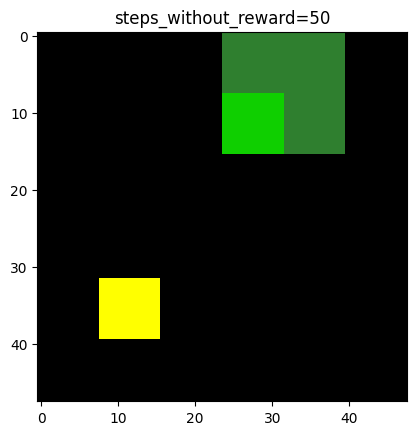

In [26]:
show_game_vectorized(ind)